In [1]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Téléchargez les ressources nécessaires pour NLTK
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
!pip install unidecode


In [4]:
import pandas as pd
import string
from unidecode import unidecode
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import nltk
from nltk.corpus import stopwords
stopwords_fr = stopwords.words('french')
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Bidirectional

from keras.layers import Dense
from keras import regularizers

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer

# Créer un dictionnaire français à partir des mots français contenus dans la liste des mots français du corpus nltk
fr_dict = set(stopwords.words('french'))

from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

2024-02-25 21:48:01.798036: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 21:48:01.798160: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 21:48:01.980261: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
df = pd.read_csv("../input/french-twitter-sentiment-analysis/french_tweets.csv")
print(df.dtypes)
print(df.head())

label     int64
text     object
dtype: object
   label                                               text
0      0  - Awww, c'est un bummer. Tu devrais avoir davi...
1      0  Est contrarié qu'il ne puisse pas mettre à jou...
2      0  J'ai plongé plusieurs fois pour la balle. A ré...
3      0  Tout mon corps a des démangeaisons et comme si...
4      0  Non, il ne se comporte pas du tout. je suis en...


In [6]:
df_echantillon = df.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 700000)))

repartition_labels = df_echantillon['label'].value_counts()
print(repartition_labels)

label
0    700000
1    700000
Name: count, dtype: int64


/tmp/ipykernel_26/1649093381.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_echantillon = df.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 700000)))


In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub("&lt;/?.*?&gt;", " &lt;&gt; ", text)
    text = re.sub(r'[@/#]', '', text)
    text = re.sub("(\\d|\\W)+", " ", text)
    text = re.sub(r'_+', '', text)
    text = unidecode(text)
    tokens = nltk.word_tokenize(text)

    text = ' '.join(tokens)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" 
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


df_echantillon['text']=df_echantillon['text'].apply(clean_text)
df_echantillon['text'] = df_echantillon['text'].apply(remove_emoji)
df_echantillon.head()

,label,text
425019,0,maintenant quittant corpus christi
137513,0,donc freakn fatigue gah je veux dormir pas tra...
174652,0,je ressens vraiment que j ai besoin d une nouv...
218508,0,hey voulez vous avoir un autre chat en direct ...
201348,0,j espere que vous n avez pas parle trop tot et...


In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_echantillon['text'])
X = tokenizer.texts_to_sequences(df_echantillon['text'])
X = pad_sequences(X)
y = np.array(df_echantillon['label'])
X = np.reshape(X, (X.shape[0],X.shape[1],1))
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
texts = df_echantillon['text'].tolist()

vocab_size = 1000

embedding_dim = 100

tokenizer = Tokenizer(num_words=vocab_size)

tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)

max_len = 100

X = pad_sequences(sequences, maxlen=max_len)

y = np.array(df_echantillon['label'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 100)          100000    
                                                                 
 bidirectional (Bidirection  (None, 100, 256)          234496    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 100, 256)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 128)               0     

I0000 00:00:1708898232.670183      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28000/28000 [==============================] - 552s 19ms/step - loss: 0.4861 - accuracy: 0.7636 - val_loss: 0.4701 - val_accuracy: 0.7731
Epoch 2/30
28000/28000 [==============================] - 528s 19ms/step - loss: 0.4625 - accuracy: 0.7788 - val_loss: 0.4602 - val_accuracy: 0.7801
Epoch 3/30
28000/28000 [==============================] - 529s 19ms/step - loss: 0.4505 - accuracy: 0.7862 - val_loss: 0.4551 - val_accuracy: 0.7829
Epoch 4/30
28000/28000 [==============================] - 530s 19ms/step - loss: 0.4413 - accuracy: 0.7915 - val_loss: 0.4548 - val_accuracy: 0.7835
Epoch 5/30
28000/28000 [==============================] - 529s 19ms/step - loss: 0.4337 - accuracy: 0.7955 - val_loss: 0.4523 - val_accuracy: 0.7855
Epoch 6/30
28000/28000 [==============================] - 530s 19ms/step - loss: 0.4271 - accuracy: 0.7993 - val_loss: 0.4532 - val_accuracy: 0.7848
Epoch 7/30
28000/28000 [==============================] - 525s 19ms/step - loss: 0.4217 - accuracy: 0.8025 - val_loss

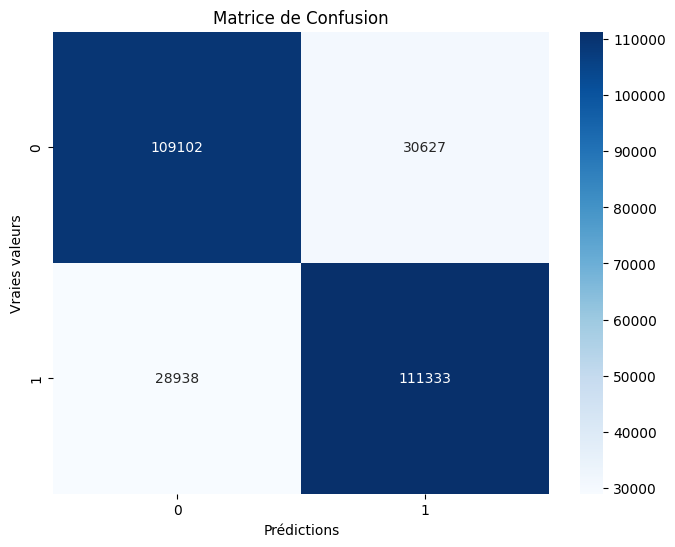

In [10]:

inputs_bi = Input(shape=(max_len,))
embedding_layer_bi = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(inputs_bi)

x_bi = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer_bi)
x_bi = Dropout(0.2)(x_bi)
x_bi = Bidirectional(LSTM(64))(x_bi)
x_bi = Dropout(0.2)(x_bi)

outputs_bi = Dense(1, activation='sigmoid')(x_bi)

modeleBi = Model(inputs=inputs_bi, outputs=outputs_bi)

modeleBi.summary()

learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)

modeleBi.compile(loss='binary_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_bi = modeleBi.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

loss_bi, accuracy_bi = modeleBi.evaluate(X_test, y_test)
print("Test Loss (BiLSTM):", loss_bi)
print("Test Accuracy (BiLSTM):", accuracy_bi)

y_pred = modeleBi.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()

In [11]:
modeleBi.save("bilstm700000.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
